In [1]:
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from torch_geometric.data import Data
from torch_geometric.utils import stochastic_blockmodel_graph, to_dense_adj
from graspologic.embed import AdjacencySpectralEmbed 

from models.RDPG_GD import GRDPG_GD_Armijo
from models.GLASE_unshared_normalized import gLASE 
from models.SVD_truncate import align_Xs
from training.link_prediction import link_prediction_Transformer

In [2]:
torch.manual_seed(42)

d = 4

n_P1 = 100 # NUMERO DE SENADORES P1
n_P2 = 100 # NUMERO DE SENADORES P2
n_L1 = 200 # NUMERO DE LEYES P1
n_L2 = 200 # NUMERO DE LEYES P2
n_L3 = 60 # NUMERO DE LEYES NEUTRAS

P1_L1 = 0.8 ## Votos de senadores del partido 1 a leyes grupo 1
P1_L2 = 0.01 ## Votos de senadores del partido 1 a leyes grupo 2
P1_L3 = 0.2 ## Votos de senadores del partido 1 a leyes grupo 3
P2_L1 = 0.01 ## Votos de senadores del partido 2 a leyes grupo 1
P2_L2 = 0.8 ## Votos de senadores del partido 2 a leyes grupo 2
P2_L3 = 0.2 ## Votos de senadores del partido 2 a leyes grupo 3


p = [
    [0, 0, P1_L1, P1_L2, P1_L3],
    [0, 0, P2_L1, P2_L2, P2_L3],
    [P1_L1, P2_L1, 0, 0, 0], 
    [P1_L2, P2_L2, 0, 0, 0], 
    [P1_L3, P2_L3, 0, 0, 0]
    ]

n = [n_P1, n_P2, n_L1, n_L2, n_L3]

num_nodes = np.sum(n)
edge_index = stochastic_blockmodel_graph(n, p)

n_P1_np = 30
n_P2_np = 24
senadores_no_presentes = list(range(n_P1_np)) + list(range(n_P1,n_P1+n_P2_np))

## CASO 1 - 0.7

In [6]:
## MASK

mask = torch.ones([num_nodes,num_nodes]).squeeze(0)
for i in senadores_no_presentes:
    votos = (torch.rand(1, n_L1+n_L2+n_L3) < 0.7).int()
    mask[i, n_P1+n_P2:] = votos
    mask[n_P1+n_P2:,i] = votos
    
    
## ASE 
adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0)
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
masked_adj = adj_matrix*mask
x_ase = ase.fit_transform(masked_adj.numpy())
x_ase = torch.from_numpy(x_ase)

A = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)

u, V = torch.linalg.eig(A)

list_q=[]
for i in range(d):
    if u[i].numpy()>0:
        list_q.append(1)
    else:
        list_q.append(-1)
        
q = torch.Tensor(list_q)
Q=torch.diag(q)
print(Q)

## GD GRDPG 
edge_index = edge_index.to('cpu')
x_grdpg, cost, k  = GRDPG_GD_Armijo(x_ase, edge_index, Q, mask.nonzero().t().contiguous())
x_grdpg = x_grdpg.detach()
print("Iteraciones: ", k)
print("Loss: ", torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask.nonzero().t().contiguous()).squeeze(0)))


## GLASE
gd_steps = 20
lr = 1e-2
device = 'cuda'
model = gLASE(d,d, gd_steps)
model.init_lase(lr)
model.to(device)


epochs = 500

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define ATT mask
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = mask.to(device)
x_ase = x_ase.to(device)
edge_index = edge_index.to(device)
Q = Q.to(device)

for epoch in range(epochs):
    # Train
    model.train()

    optimizer.zero_grad()
    out = model(x_ase, edge_index, edge_index_2, Q, mask.nonzero().t().contiguous())
    loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
    loss.backward() 
    optimizer.step() 

    if epoch % 100 ==0:
        print(loss)
        
loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
print(loss)
x_glase = out.detach().to('cpu')
x_ase = x_ase.to('cpu')


x_grdpg_p = align_Xs(x_grdpg, x_ase)
x_glase_p = align_Xs(x_glase, x_ase)


torch.manual_seed(42)
random_features=torch.rand([num_nodes, 5])
masked_edge_index = masked_adj.nonzero().t().contiguous()
data = Data(x=random_features.float(), x_init = x_ase, x_ase=x_ase, x_glase=x_glase, x_grdpg=x_grdpg, edge_index=masked_edge_index)

tensor([[-1.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  1.]])
Iteraciones:  25
Loss:  tensor(125.2960)
tensor(329.4015, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(128.1578, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(125.5955, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(125.4124, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(125.4040, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(125.3985, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


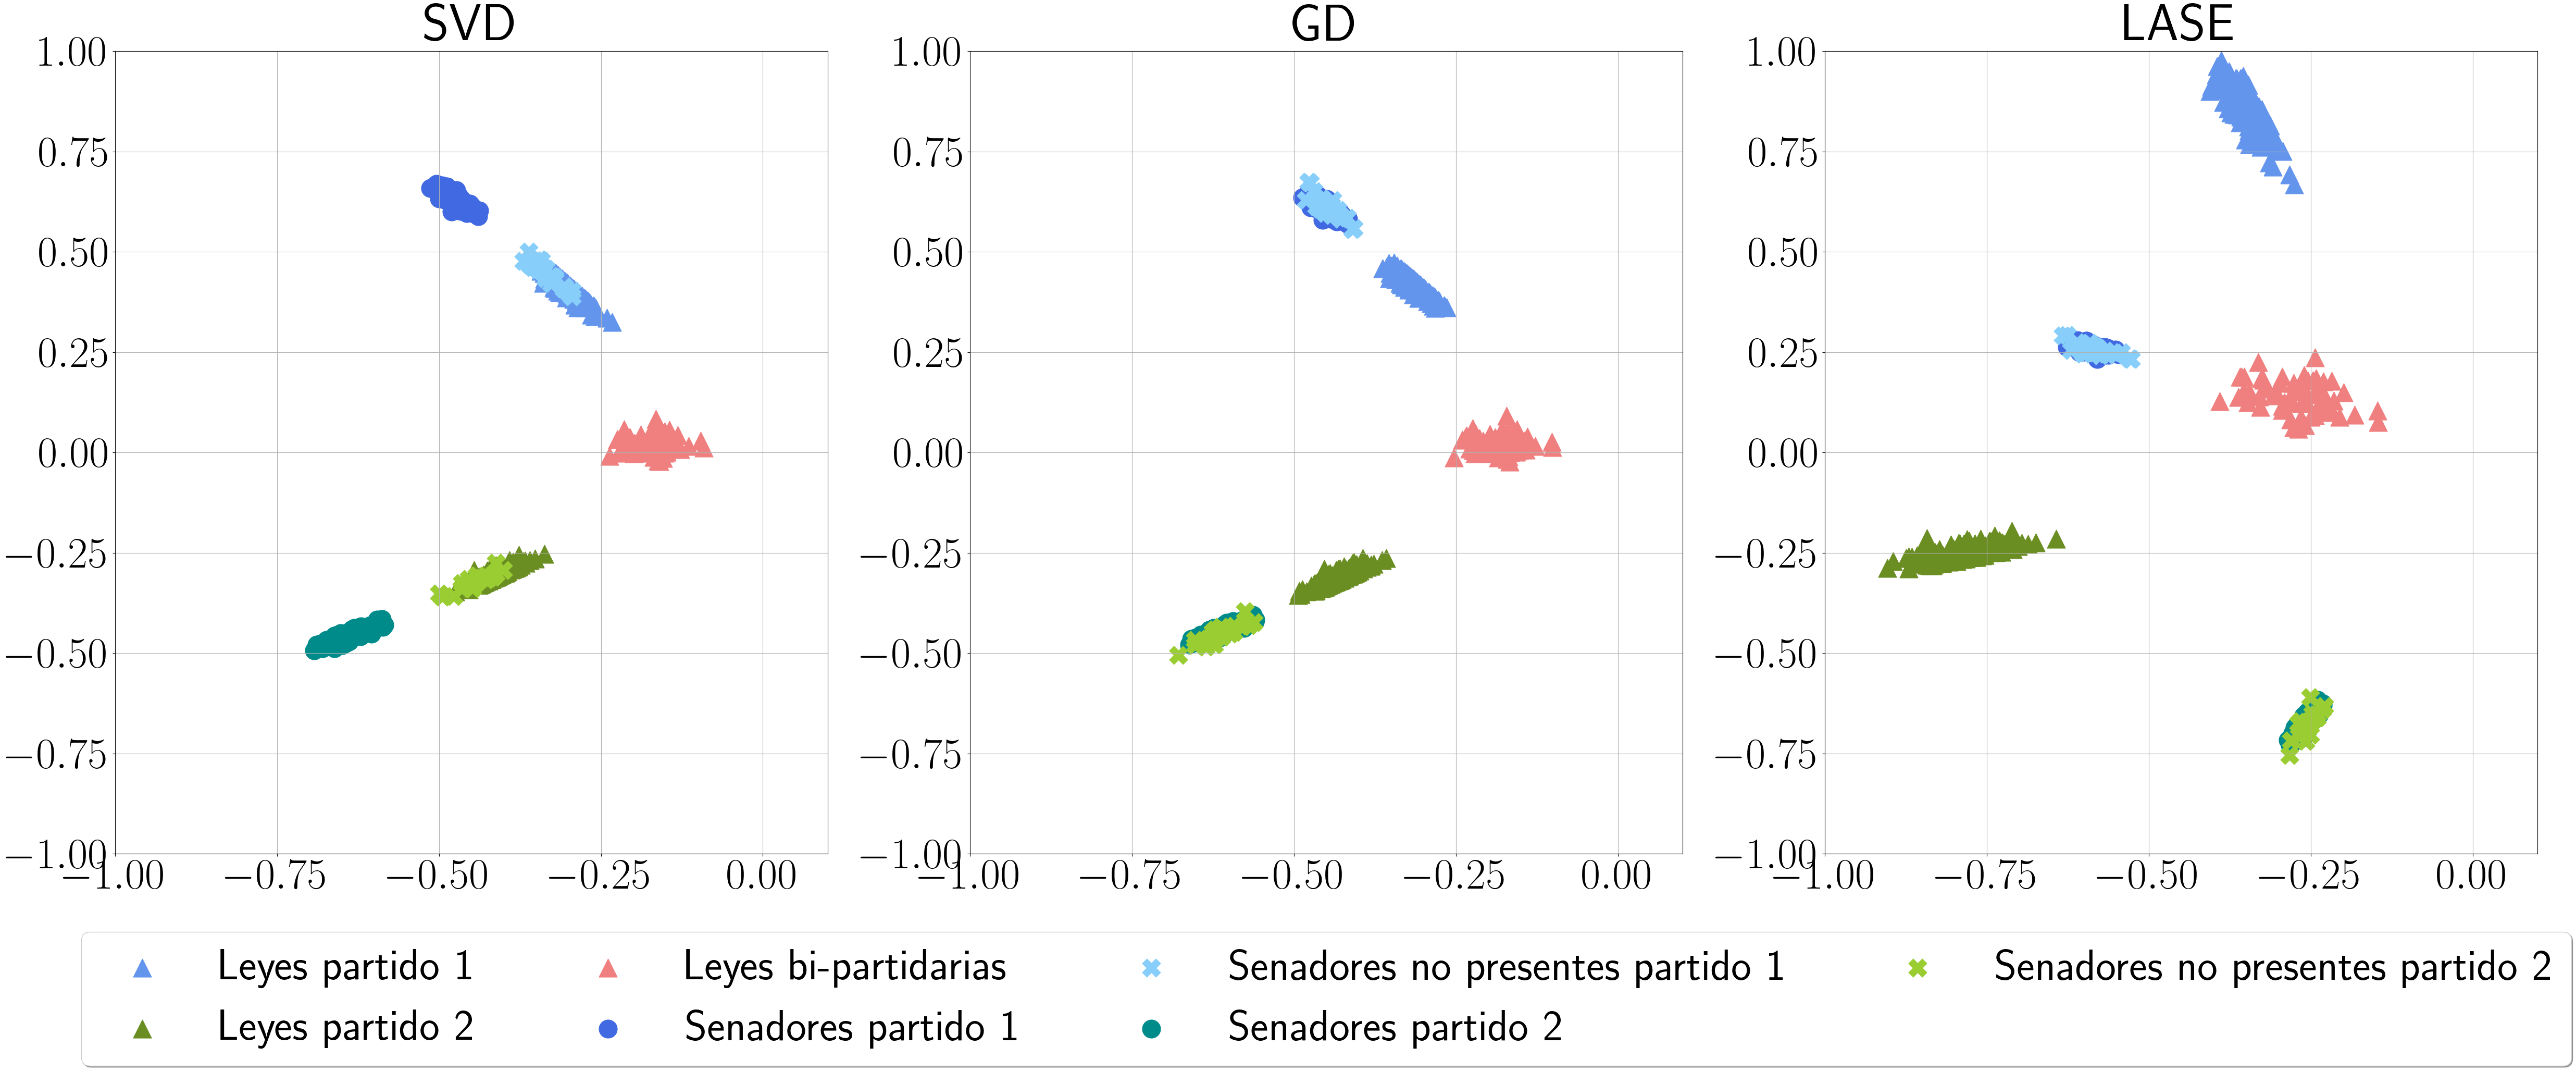

In [14]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 60
plt.rcParams['lines.markersize'] = 25
plt.rcParams['axes.grid'] = True


fig, axes = plt.subplots(1, 3, figsize =(60,20))

axes[0].scatter(x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Leyes partido 1')
axes[0].scatter(x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='olivedrab',marker='^',label='Leyes partido 2')
axes[0].scatter(x_ase[n_P1+n_P2+n_L1+n_L2:,0],x_ase[n_P1+n_P2+n_L1+n_L2:,2],c='lightcoral',marker='^',label='Leyes bi-partidarias')
axes[0].scatter(x_ase[n_P1_np:n_P1,0],x_ase[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Senadores partido 1')
axes[0].scatter(x_ase[:n_P1_np,0],x_ase[:n_P1_np,2], c='lightskyblue',marker='X',label='Senadores no presentes partido 1')
axes[0].scatter(x_ase[n_P1+n_P2_np:n_P1+n_P2,0],x_ase[n_P1+n_P2_np:n_P1+n_P2,2], c='darkcyan',marker='o',label='Senadores partido 2')
axes[0].scatter(x_ase[n_P1:n_P1+n_P2_np,0],x_ase[n_P1:n_P1+n_P2_np,2], c='yellowgreen',marker='X',label='Senadores no presentes partido 2')
axes[0].set_title('SVD')
axes[0].set_xlim(-1,0.1)
axes[0].set_ylim(-1,1)

axes[1].scatter(x_grdpg_p[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_grdpg_p[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Leyes partido 1')
axes[1].scatter(x_grdpg_p[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_grdpg_p[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='olivedrab',marker='^',label='Leyes partido 2')
axes[1].scatter(x_grdpg_p[n_P1+n_P2+n_L1+n_L2:,0],x_grdpg_p[n_P1+n_P2+n_L1+n_L2:,2],c='lightcoral',marker='^',label='Leyes bi-partidarias')
axes[1].scatter(x_grdpg_p[n_P1_np:n_P1,0],x_grdpg_p[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Senadores partido 1')
axes[1].scatter(x_grdpg_p[:n_P1_np,0],x_grdpg_p[:n_P1_np,2], c='lightskyblue',marker='X',label='Senadores no presentes partido 1')
axes[1].scatter(x_grdpg_p[n_P1+n_P2_np:n_P1+n_P2,0],x_grdpg_p[n_P1+n_P2_np:n_P1+n_P2,2], c='darkcyan',marker='o',label='Senadores partido 2')
axes[1].scatter(x_grdpg_p[n_P1:n_P1+n_P2_np,0],x_grdpg_p[n_P1:n_P1+n_P2_np,2], c='yellowgreen',marker='X',label='Senadores no presentes partido 2')
axes[1].set_title('GD')
axes[1].set_xlim(-1,0.1)
axes[1].set_ylim(-1,1)

axes[2].scatter(x_glase_p[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_glase_p[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Leyes partido 1')
axes[2].scatter(x_glase_p[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_glase_p[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='olivedrab',marker='^',label='Leyes partido 2')
axes[2].scatter(x_glase_p[n_P1+n_P2+n_L1+n_L2:,0],x_glase_p[n_P1+n_P2+n_L1+n_L2:,2],c='lightcoral',marker='^',label='Leyes bi-partidarias')
axes[2].scatter(x_glase_p[n_P1_np:n_P1,0],x_glase_p[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Senadores partido 1')
axes[2].scatter(x_glase_p[:n_P1_np,0],x_glase_p[:n_P1_np,2], c='lightskyblue',marker='X',label='Senadores no presentes partido 1')
axes[2].scatter(x_glase_p[n_P1+n_P2_np:n_P1+n_P2,0],x_glase_p[n_P1+n_P2_np:n_P1+n_P2,2], c='darkcyan',marker='o',label='Senadores partido 2')
axes[2].scatter(x_glase_p[n_P1:n_P1+n_P2_np,0],x_glase_p[n_P1:n_P1+n_P2_np,2], c='yellowgreen',marker='X',label='Senadores no presentes partido 2')
axes[2].set_title('LASE')
axes[2].set_xlim(-1,0.1)
axes[2].set_ylim(-1,1)

# axes[3].scatter(x_glase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_glase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Leyes partido 1')
# axes[3].scatter(x_glase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_glase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='olivedrab',marker='^',label='Leyes partido 2')
# axes[3].scatter(x_glase[n_P1+n_P2+n_L1+n_L2:,0],x_glase[n_P1+n_P2+n_L1+n_L2:,2],c='lightcoral',marker='^',label='Leyes bi-partidarias')
# axes[3].scatter(x_glase[n_P1_np:n_P1,0],x_glase[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Senadores partido 1')
# axes[3].scatter(x_glase[:n_P1_np,0],x_glase[:n_P1_np,2], c='lightskyblue',marker='X',label='Senadores no presentes partido 1')
# axes[3].scatter(x_glase[n_P1+n_P2_np:n_P1+n_P2,0],x_glase[n_P1+n_P2_np:n_P1+n_P2,2], c='darkcyan',marker='o',label='Senadores partido 2')
# axes[3].scatter(x_glase[n_P1:n_P1+n_P2_np,0],x_glase[n_P1:n_P1+n_P2_np,2], c='yellowgreen',marker='X',label='Senadores no presentes partido 2')
# axes[3].set_title('LASE')
# axes[3].set_xlim(-1.5,0.5)
# axes[3].set_ylim(-0.75,0.75)

plt.legend(loc='upper center', bbox_to_anchor=(-0.7, -0.07),fancybox=True, shadow=True, ncol=4)
plt.show()


In [9]:
inverted_mask_matrix = (torch.ones([num_nodes,num_nodes]).squeeze(0) - mask.to('cpu'))
model_1, model_2, model_3, model_4, model_5, acc_gcn, acc_ase, acc_grdpg, acc_glase, acc_glase_e2e = link_prediction_Transformer(edge_index, edge_index_2, Q, mask, inverted_mask_matrix, data, 5, 4)

print(f'GCN acc: {acc_gcn:.4f}, ASE acc: {acc_ase:.4f}, GD-GRDPG acc: {acc_grdpg:.4f}, GLASE acc: {acc_glase:.4f}, GLASE E2E acc: {acc_glase_e2e:.4f}')

GCN acc: 0.4216, ASE acc: 0.8462, GD-GRDPG acc: 0.8449, GLASE acc: 0.8441, GLASE E2E acc: 0.8484


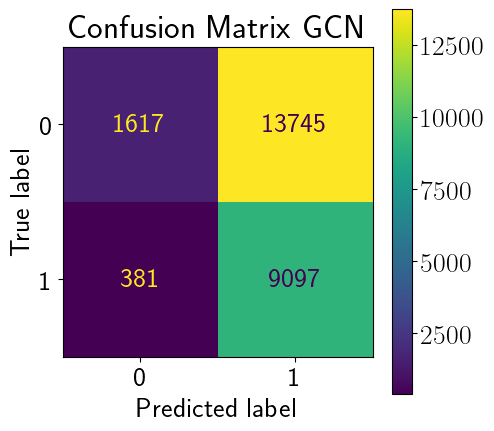

In [11]:
### Matriz de confusión GCN

x_eval = data.x
num_nodes = adj_matrix.shape[0]
z = model_1.encode(x_eval, data.edge_index)
final_edge_index = model_1.decode_all(z)
predicted_adj = to_dense_adj(final_edge_index, max_num_nodes=num_nodes).squeeze(0).to('cpu')

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20
plt.rcParams['lines.markersize'] = 15
plt.rcParams['axes.grid'] = False

# Assuming you have two tensors named 'actual' and 'predicted'
actual = adj_matrix[senadores_no_presentes,n_P1+n_P2:].view(-1)
predicted = predicted_adj[senadores_no_presentes,n_P1+n_P2:].view(-1)

# Convert tensors to numpy arrays
actual_np = actual.numpy()
predicted_np = predicted.numpy()

# Build confusion matrix
conf_matrix = confusion_matrix(actual_np, predicted_np)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['0', '1'])
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)
plt.title('Confusion Matrix GCN')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# CASO 1 - 0.5

In [12]:
mask = torch.ones([num_nodes,num_nodes]).squeeze(0)
for i in senadores_no_presentes:
    votos = (torch.rand(1, n_L1+n_L2+n_L3) < 0.5).int()
    mask[i, n_P1+n_P2:] = votos
    mask[n_P1+n_P2:,i] = votos
    
    
## ASE 
adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0)
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
masked_adj = adj_matrix*mask
x_ase = ase.fit_transform(masked_adj.numpy())
x_ase = torch.from_numpy(x_ase)

A = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)

u, V = torch.linalg.eig(A)

list_q=[]
for i in range(d):
    if u[i].numpy()>0:
        list_q.append(1)
    else:
        list_q.append(-1)
        
q = torch.Tensor(list_q)
Q=torch.diag(q)
print(Q)

## GD GRDPG 
edge_index = edge_index.to('cpu')
x_grdpg, cost, k  = GRDPG_GD_Armijo(x_ase, edge_index, Q, mask.nonzero().t().contiguous())
x_grdpg = x_grdpg.detach()
print("Iteraciones: ", k)
print("Loss: ", torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask.nonzero().t().contiguous()).squeeze(0)))


## GLASE

gd_steps = 20
lr = 1e-2
device = 'cuda'
model = gLASE(d,d, gd_steps)
model.init_lase(lr)
model.to(device)


epochs = 400
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define ATT mask
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = mask.to(device)
x_ase = x_ase.to(device)
edge_index = edge_index.to(device)
Q = Q.to(device)

for epoch in range(epochs):
    # Train
    model.train()

    optimizer.zero_grad()
    out = model(x_ase, edge_index, edge_index_2, Q, mask.nonzero().t().contiguous())
    loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
    loss.backward() 
    optimizer.step() 

    if epoch % 100 ==0:
        print(loss)
        
loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
print(loss)
x_glase = out.detach().to('cpu')
x_ase = x_ase.to('cpu')

from models.SVD_truncate import align_Xs
x_grdpg = align_Xs(x_grdpg, x_ase)
x_glase = align_Xs(x_glase, x_ase)


torch.manual_seed(42)
random_features=torch.rand([num_nodes, 5])
masked_edge_index = masked_adj.nonzero().t().contiguous()
data = Data(x=random_features.float(), x_init = x_ase, x_ase=x_ase, x_glase=x_glase, x_grdpg=x_grdpg, edge_index=masked_edge_index)

tensor([[-1.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  1.]])
Iteraciones:  24
Loss:  tensor(121.5747)
tensor(319.7515, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(123.4974, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(121.7518, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(121.7594, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(121.7023, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


In [13]:
inverted_mask_matrix = (torch.ones([num_nodes,num_nodes]).squeeze(0) - mask.to('cpu'))
model_1, model_2, model_3, model_4, model_5, acc_gcn, acc_ase, acc_grdpg, acc_glase, acc_glase_e2e = link_prediction_Transformer(edge_index, edge_index_2, Q, mask, inverted_mask_matrix, data, 5, 4)
print(f'GCN acc: {acc_gcn:.4f}, ASE acc: {acc_ase:.4f}, GD-GRDPG acc: {acc_grdpg:.4f}, GLASE acc: {acc_glase:.4f}, GLASE E2E acc: {acc_glase_e2e:.4f}')

GCN acc: 0.4417, ASE acc: 0.8478, GD-GRDPG acc: 0.8487, GLASE acc: 0.8470, GLASE E2E acc: 0.8463


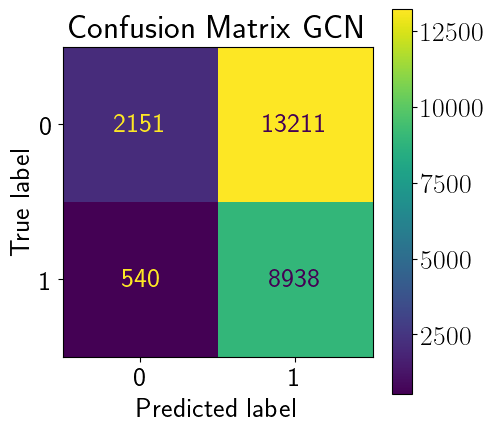

In [14]:
### Matriz de confusión GCN

x_eval = data.x
num_nodes = adj_matrix.shape[0]
z = model_1.encode(x_eval, data.edge_index)
final_edge_index = model_1.decode_all(z)
predicted_adj = to_dense_adj(final_edge_index, max_num_nodes=num_nodes).squeeze(0).to('cpu')

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20
plt.rcParams['lines.markersize'] = 15
plt.rcParams['axes.grid'] = False

# Assuming you have two tensors named 'actual' and 'predicted'
actual = adj_matrix[senadores_no_presentes,n_P1+n_P2:].view(-1)
predicted = predicted_adj[senadores_no_presentes,n_P1+n_P2:].view(-1)

# Convert tensors to numpy arrays
actual_np = actual.numpy()
predicted_np = predicted.numpy()

# Build confusion matrix
conf_matrix = confusion_matrix(actual_np, predicted_np)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['0', '1'])
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)
plt.title('Confusion Matrix GCN')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# CASO 1 - 0.3

In [15]:
mask = torch.ones([num_nodes,num_nodes]).squeeze(0)
for i in senadores_no_presentes:
    votos = (torch.rand(1, n_L1+n_L2+n_L3) < 0.3).int()
    mask[i, n_P1+n_P2:] = votos
    mask[n_P1+n_P2:,i] = votos
    
    
## ASE 
adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0)
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
masked_adj = adj_matrix*mask
x_ase = ase.fit_transform(masked_adj.numpy())
x_ase = torch.from_numpy(x_ase)

A = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)

u, V = torch.linalg.eig(A)

list_q=[]
for i in range(d):
    if u[i].numpy()>0:
        list_q.append(1)
    else:
        list_q.append(-1)
q = torch.Tensor(list_q)
Q=torch.diag(q)

print(Q)

## GD GRDPG 
edge_index = edge_index.to('cpu')
x_grdpg, cost, k  = GRDPG_GD_Armijo(x_ase, edge_index, Q, mask.nonzero().t().contiguous())
x_grdpg = x_grdpg.detach()
print("Iteraciones: ", k)
print("Loss: ", torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask.nonzero().t().contiguous()).squeeze(0)))


## GLASE

gd_steps = 20
lr = 1e-2
device = 'cuda'
model = gLASE(d,d, gd_steps)
model.init_lase(lr)
model.to(device)


epochs = 500
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define ATT mask
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = mask.to(device)
x_ase = x_ase.to(device)
edge_index = edge_index.to(device)
Q = Q.to(device)

for epoch in range(epochs):
    # Train
    model.train()

    optimizer.zero_grad()
    out = model(x_ase, edge_index, edge_index_2, Q, mask.nonzero().t().contiguous())
    loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
    loss.backward() 
    optimizer.step() 

    if epoch % 100 ==0:
        print(loss)
        
loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
print(loss)
x_glase = out.detach().to('cpu')
x_ase = x_ase.to('cpu')

from models.SVD_truncate import align_Xs
x_grdpg = align_Xs(x_grdpg, x_ase)
x_glase = align_Xs(x_glase, x_ase)


torch.manual_seed(42)
random_features=torch.rand([num_nodes, 5])
masked_edge_index = masked_adj.nonzero().t().contiguous()
data = Data(x=random_features.float(), x_init = x_ase, x_ase=x_ase, x_glase=x_glase, x_grdpg=x_grdpg, edge_index=masked_edge_index)

tensor([[-1.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  1.]])
Iteraciones:  31
Loss:  tensor(117.6995)
tensor(309.9775, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(120.6587, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(118.1286, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(117.8562, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(117.8220, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(117.8215, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


In [16]:
inverted_mask_matrix = (torch.ones([num_nodes,num_nodes]).squeeze(0) - mask.to('cpu'))
model_1, model_2, model_3, model_4, model_5, acc_gcn, acc_ase, acc_grdpg, acc_glase, acc_glase_e2e = link_prediction_Transformer(edge_index, edge_index_2, Q, mask, inverted_mask_matrix, data, 5, 4)
print(f'GCN acc: {acc_gcn:.4f}, ASE acc: {acc_ase:.4f}, GD-GRDPG acc: {acc_grdpg:.4f}, GLASE acc: {acc_glase:.4f}, GLASE E2E acc: {acc_glase_e2e:.4f}')

GCN acc: 0.5440, ASE acc: 0.8459, GD-GRDPG acc: 0.8356, GLASE acc: 0.8484, GLASE E2E acc: 0.8428


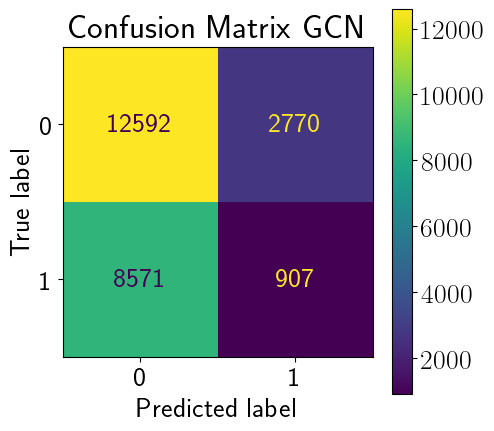

In [18]:
### Matriz de confusión GCN

x_eval = data.x
num_nodes = adj_matrix.shape[0]
z = model_1.encode(x_eval, data.edge_index)
final_edge_index = model_1.decode_all(z)
predicted_adj = to_dense_adj(final_edge_index, max_num_nodes=num_nodes).squeeze(0).to('cpu')

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20
plt.rcParams['lines.markersize'] = 15
plt.rcParams['axes.grid'] = False

# Assuming you have two tensors named 'actual' and 'predicted'
actual = adj_matrix[senadores_no_presentes,n_P1+n_P2:].view(-1)
predicted = predicted_adj[senadores_no_presentes,n_P1+n_P2:].view(-1)

# Convert tensors to numpy arrays
actual_np = actual.numpy()
predicted_np = predicted.numpy()

# Build confusion matrix
conf_matrix = confusion_matrix(actual_np, predicted_np)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['0', '1'])
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)
plt.title('Confusion Matrix GCN')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# CASO 1 - 0.1

In [19]:
mask = torch.ones([num_nodes,num_nodes]).squeeze(0)
for i in senadores_no_presentes:
    votos = (torch.rand(1, n_L1+n_L2+n_L3) < 0.1).int()
    mask[i, n_P1+n_P2:] = votos
    mask[n_P1+n_P2:,i] = votos
    
    
## ASE 
adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0)
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
masked_adj = adj_matrix*mask
x_ase = ase.fit_transform(masked_adj.numpy())
x_ase = torch.from_numpy(x_ase)

A = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)

u, V = torch.linalg.eig(A)

list_q=[]
for i in range(d):
    if u[i].numpy()>0:
        list_q.append(1)
    else:
        list_q.append(-1)
        
q = torch.Tensor(list_q)
Q=torch.diag(q)

print(Q)

## GD GRDPG 
edge_index = edge_index.to('cpu')
x_grdpg, cost, k  = GRDPG_GD_Armijo(x_ase, edge_index, Q, mask.nonzero().t().contiguous())
x_grdpg = x_grdpg.detach()
print("Iteraciones: ", k)
print("Loss: ", torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask.nonzero().t().contiguous()).squeeze(0)))


## GLASE

gd_steps = 20
lr = 1e-2
device = 'cuda'
model = gLASE(d,d, gd_steps)
model.init_lase(lr)
model.to(device)


epochs = 500
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define ATT mask
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = mask.to(device)
x_ase = x_ase.to(device)
edge_index = edge_index.to(device)
Q = Q.to(device)

for epoch in range(epochs):
    # Train
    model.train()

    optimizer.zero_grad()
    out = model(x_ase, edge_index, edge_index_2, Q, mask.nonzero().t().contiguous())
    loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
    loss.backward() 
    optimizer.step() 

    if epoch % 100 ==0:
        print(loss)
        
loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
print(loss)
x_glase = out.detach().to('cpu')
x_ase = x_ase.to('cpu')

from models.SVD_truncate import align_Xs
x_grdpg = align_Xs(x_grdpg, x_ase)
x_glase = align_Xs(x_glase, x_ase)


torch.manual_seed(42)
random_features=torch.rand([num_nodes, 5])
masked_edge_index = masked_adj.nonzero().t().contiguous()
data = Data(x=random_features.float(), x_init = x_ase, x_ase=x_ase, x_glase=x_glase, x_grdpg=x_grdpg, edge_index=masked_edge_index)

tensor([[-1.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  1.]])
Iteraciones:  100
Loss:  tensor(182.4353)
tensor(301.5136, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(117.2318, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(115.9090, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(115.8614, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(115.9748, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(115.8210, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


In [20]:
inverted_mask_matrix = (torch.ones([num_nodes,num_nodes]).squeeze(0) - mask.to('cpu'))
model_1, model_2, model_3, model_4, model_5, acc_gcn, acc_ase, acc_grdpg, acc_glase, acc_glase_e2e = link_prediction_Transformer(edge_index, edge_index_2, Q, mask, inverted_mask_matrix, data, 5, 4)
print(f'GCN acc: {acc_gcn:.4f}, ASE acc: {acc_ase:.4f}, GD-GRDPG acc: {acc_grdpg:.4f}, GLASE acc: {acc_glase:.4f}, GLASE E2E acc: {acc_glase_e2e:.4f}')

GCN acc: 0.5521, ASE acc: 0.8443, GD-GRDPG acc: 0.8271, GLASE acc: 0.8413, GLASE E2E acc: 0.8438


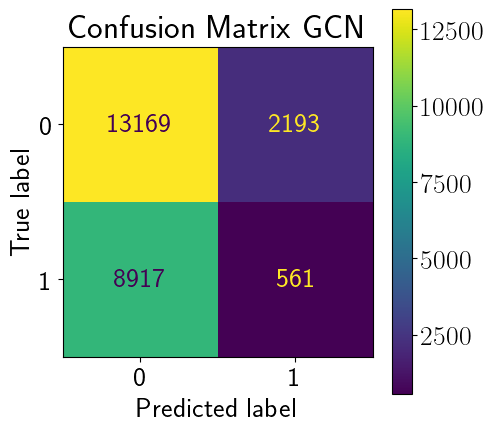

In [21]:
### Matriz de confusión GCN

x_eval = data.x
num_nodes = adj_matrix.shape[0]
z = model_1.encode(x_eval, data.edge_index)
final_edge_index = model_1.decode_all(z)
predicted_adj = to_dense_adj(final_edge_index, max_num_nodes=num_nodes).squeeze(0).to('cpu')

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20
plt.rcParams['lines.markersize'] = 15
plt.rcParams['axes.grid'] = False

# Assuming you have two tensors named 'actual' and 'predicted'
actual = adj_matrix[senadores_no_presentes,n_P1+n_P2:].view(-1)
predicted = predicted_adj[senadores_no_presentes,n_P1+n_P2:].view(-1)

# Convert tensors to numpy arrays
actual_np = actual.numpy()
predicted_np = predicted.numpy()

# Build confusion matrix
conf_matrix = confusion_matrix(actual_np, predicted_np)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['0', '1'])
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)
plt.title('Confusion Matrix GCN')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Analisis resultados CASO 1

In [26]:
with open(f'../training/results/senators/link_pred_senators_results_07.pkl', 'rb') as f:
    results_07= pickle.load(f)

with open(f'../training/results/senators/link_pred_senators_results_05.pkl', 'rb') as f:
    results_05= pickle.load(f)

with open(f'../training/results/senators/link_pred_senators_results_03.pkl', 'rb') as f:
    results_03= pickle.load(f)

with open(f'../training/results/senators/link_pred_senators_results_01.pkl', 'rb') as f:
    results_01= pickle.load(f)

In [27]:
print(f'{np.array(results_07["gcn"]).mean():.4f}, {np.array(results_07["gcn"]).std():.4f}')
print(f'{np.array(results_05["gcn"]).mean():.4f}, {np.array(results_05["gcn"]).std():.4f}')
print(f'{np.array(results_03["gcn"]).mean():.4f}, {np.array(results_03["gcn"]).std():.4f}')
print(f'{np.array(results_01["gcn"]).mean():.4f}, {np.array(results_01["gcn"]).std():.4f}')

0.4320, 0.0230
0.4411, 0.0088
0.5409, 0.0109
0.5508, 0.0021


In [28]:
print(f'{np.array(results_07["ase"]).mean():.4f}, {np.array(results_07["ase"]).std():.4f}')
print(f'{np.array(results_05["ase"]).mean():.4f}, {np.array(results_05["ase"]).std():.4f}')
print(f'{np.array(results_03["ase"]).mean():.4f}, {np.array(results_03["ase"]).std():.4f}')
print(f'{np.array(results_01["ase"]).mean():.4f}, {np.array(results_01["ase"]).std():.4f}')

0.8437, 0.0027
0.8474, 0.0016
0.8458, 0.0037
0.8390, 0.0077


In [29]:
print(f'{np.array(results_07["glase"]).mean():.4f}, {np.array(results_07["glase"]).std():.4f}')
print(f'{np.array(results_05["glase"]).mean():.4f}, {np.array(results_05["glase"]).std():.4f}')
print(f'{np.array(results_03["glase"]).mean():.4f}, {np.array(results_03["glase"]).std():.4f}')
print(f'{np.array(results_01["glase"]).mean():.4f}, {np.array(results_01["glase"]).std():.4f}')

0.8437, 0.0021
0.8454, 0.0024
0.8437, 0.0043
0.8298, 0.0268


In [30]:
print(f'{np.array(results_07["glase_e2e"]).mean():.4f}, {np.array(results_07["glase_e2e"]).std():.4f}')
print(f'{np.array(results_05["glase_e2e"]).mean():.4f}, {np.array(results_05["glase_e2e"]).std():.4f}')
print(f'{np.array(results_03["glase_e2e"]).mean():.4f}, {np.array(results_03["glase_e2e"]).std():.4f}')
print(f'{np.array(results_01["glase_e2e"]).mean():.4f}, {np.array(results_01["glase_e2e"]).std():.4f}')

0.8441, 0.0019
0.8482, 0.0023
0.8434, 0.0069
0.8360, 0.0120


# CASO 2 - 0.7

tensor([[ 1.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0., -1.]])
Iteraciones:  100
Loss:  tensor(149.4594)
tensor(151.0931, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(149.7625, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(149.5316, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(149.5171, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


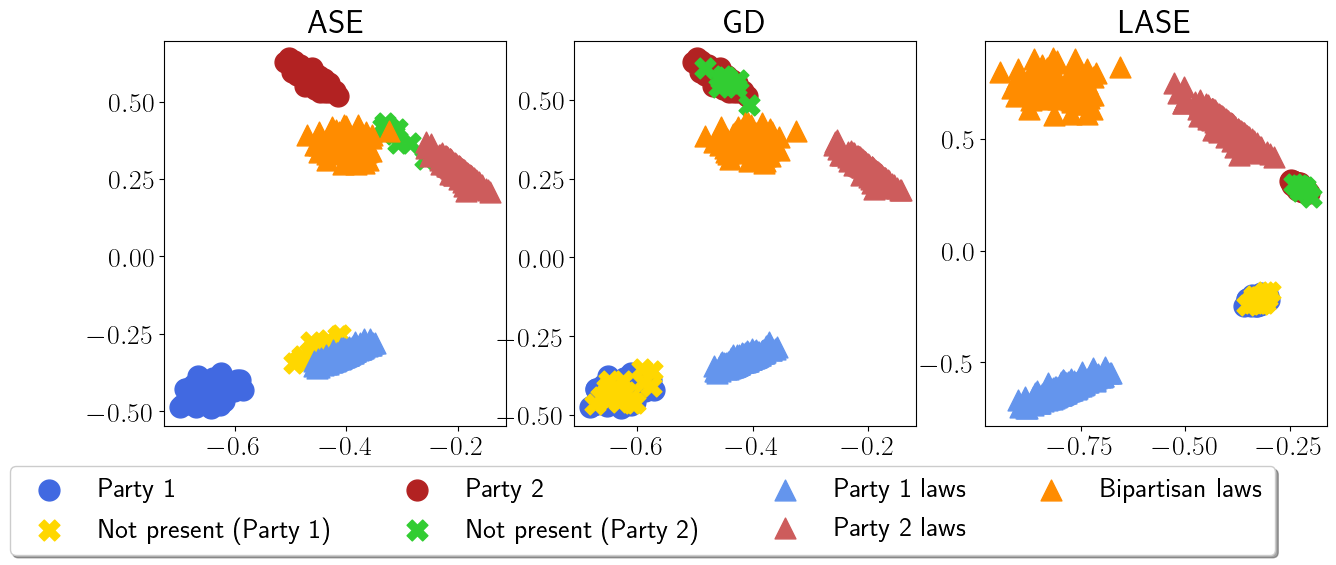

In [22]:
torch.manual_seed(42)

d = 4
n_P1 = 100
n_P2 = 100
n_L1 = 200
n_L2 = 200
n_L3 = 100

P1_L1 = 0.8
P1_L2 = 0.01
P1_L3 = 0.2 
P2_L1 = 0.01
P2_L2 = 0.5
P2_L3 = 0.8


p = [
    [0, 0, P1_L1, P1_L2, P1_L3],
    [0, 0, P2_L1, P2_L2, P2_L3],
    [P1_L1, P2_L1, 0, 0, 0], 
    [P1_L2, P2_L2, 0, 0, 0], 
    [P1_L3, P2_L3, 0, 0, 0]
    ]

n = [n_P1, n_P2, n_L1, n_L2, n_L3]

num_nodes = np.sum(n)
edge_index = stochastic_blockmodel_graph(n, p)


## MASK
n_P1_np = 20
n_P2_np = 10
senadores_no_presentes = list(range(n_P1_np)) + list(range(n_P1,n_P1+n_P2_np))

mask = torch.ones([num_nodes,num_nodes]).squeeze(0)
for i in senadores_no_presentes:
    votos = (torch.rand(1, num_nodes) < 0.7).int()
    mask[i,:] = votos
    mask[:,i] = votos
    
    
## ASE 
adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0)
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
masked_adj = adj_matrix*mask
x_ase = ase.fit_transform(masked_adj.numpy())
x_ase = torch.from_numpy(x_ase)

A = to_dense_adj(edge_index.to('cpu'), max_num_nodes=num_nodes).squeeze(0)

u, V = torch.linalg.eig(A)

list_q=[]
for i in range(d):
    if u[i].numpy()>0:
        list_q.append(1)
    else:
        list_q.append(-1)
q = torch.Tensor(list_q)
Q=torch.diag(q)
print(Q)


x_grdpg, cost, k  = GRDPG_GD_Armijo(x_ase, edge_index, Q, mask.nonzero().t().contiguous())
x_grdpg = x_grdpg.detach()
print("Iteraciones: ", k)
print("Loss: ", torch.norm((x_grdpg@Q@x_grdpg.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask.nonzero().t().contiguous()).squeeze(0)))

gd_steps = 20
lr = 1e-2
device = 'cuda'
model = gLASE(d,d, gd_steps)
model.init_lase(lr)
model.to(device)

epochs = 300
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define ATT mask
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = mask.to(device)
x_ase = x_ase.to(device)
edge_index = edge_index.to(device)
Q = Q.to(device)

for epoch in range(epochs):
    # Train
    model.train()

    optimizer.zero_grad()
    out = model(x_ase, edge_index, edge_index_2, Q, mask.nonzero().t().contiguous())
    loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
    loss.backward() 
    optimizer.step() 

    if epoch % 100 ==0:
        print(loss)
        
loss = torch.norm((out@Q@out.T - to_dense_adj(edge_index).squeeze(0))*mask)
print(loss)
x_glase = out.detach().to('cpu')
x_ase = x_ase.to('cpu')

from models.SVD_truncate import align_Xs
x_grdpg = align_Xs(x_grdpg, x_ase)
x_glase = align_Xs(x_glase, x_ase)


fig, axes = plt.subplots(1, 3, figsize =(15,5))
axes[0].scatter(x_ase[n_P1_np:n_P1,0],x_ase[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[0].scatter(x_ase[:n_P1_np,0],x_ase[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
axes[0].scatter(x_ase[n_P1+n_P2_np:n_P1+n_P2,0],x_ase[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
axes[0].scatter(x_ase[n_P1:n_P1+n_P2_np,0],x_ase[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
axes[0].scatter(x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_ase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[0].scatter(x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_ase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[0].scatter(x_ase[n_P1+n_P2+n_L1+n_L2:,0],x_ase[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
axes[0].set_title('ASE')

axes[1].scatter(x_grdpg[n_P1_np:n_P1,0],x_grdpg[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[1].scatter(x_grdpg[:n_P1_np,0],x_grdpg[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
axes[1].scatter(x_grdpg[n_P1+n_P2_np:n_P1+n_P2,0],x_grdpg[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
axes[1].scatter(x_grdpg[n_P1:n_P1+n_P2_np,0],x_grdpg[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
axes[1].scatter(x_grdpg[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_grdpg[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[1].scatter(x_grdpg[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_grdpg[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[1].scatter(x_grdpg[n_P1+n_P2+n_L1+n_L2:,0],x_grdpg[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
axes[1].set_title('GD')

axes[2].scatter(x_glase[n_P1_np:n_P1,0],x_glase[n_P1_np:n_P1,2], c='royalblue',marker='o',label='Party 1')
axes[2].scatter(x_glase[:n_P1_np,0],x_glase[:n_P1_np,2], c='gold',marker='X',label='Not present (Party 1)')
axes[2].scatter(x_glase[n_P1+n_P2_np:n_P1+n_P2,0],x_glase[n_P1+n_P2_np:n_P1+n_P2,2], c='firebrick',marker='o',label='Party 2')
axes[2].scatter(x_glase[n_P1:n_P1+n_P2_np,0],x_glase[n_P1:n_P1+n_P2_np,2], c='limegreen',marker='X',label='Not present (Party 2)')
axes[2].scatter(x_glase[n_P1+n_P2:n_P1+n_P2+n_L1,0],x_glase[n_P1+n_P2:n_P1+n_P2+n_L1,2], c='cornflowerblue',marker='^',label='Party 1 laws')
axes[2].scatter(x_glase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,0],x_glase[n_P1+n_P2+n_L1:n_P1+n_P2+n_L1+n_L2,2],c='indianred',marker='^',label='Party 2 laws')
axes[2].scatter(x_glase[n_P1+n_P2+n_L1+n_L2:,0],x_glase[n_P1+n_P2+n_L1+n_L2:,2],c='darkorange',marker='^',label='Bipartisan laws')
axes[2].set_title('LASE')
plt.legend(loc='upper center', bbox_to_anchor=(-1, -0.07),fancybox=True, shadow=True, ncol=4)
plt.show()

torch.manual_seed(42)
random_features=torch.rand([num_nodes, 5])
masked_edge_index = masked_adj.nonzero().t().contiguous()
data = Data(x=random_features.float(), x_init=x_ase, x_ase=x_ase, x_glase=x_glase, x_grdpg=x_grdpg, edge_index=masked_edge_index)

In [23]:
inverted_mask_matrix = (torch.ones([num_nodes,num_nodes]).squeeze(0) - mask.to('cpu'))
model_1, model_2, model_3, model_4, model_5, acc_gcn, acc_ase, acc_grdpg, acc_glase, acc_glase_e2e = link_prediction_Transformer(edge_index, edge_index_2, Q, mask, inverted_mask_matrix, data, 5, 4)
print(f'GCN acc: {acc_gcn:.4f}, ASE acc: {acc_ase:.4f}, GD-GRDPG acc: {acc_grdpg:.4f}, GLASE acc: {acc_glase:.4f}, GLASE E2E acc: {acc_glase_e2e:.4f}')

GCN acc: 0.2686, ASE acc: 0.7414, GD-GRDPG acc: 0.7390, GLASE acc: 0.7414, GLASE E2E acc: 0.7414
